In [35]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString


#### 00 read data
data_routes = gpd.read_file("../dat/geo-strecke/strecken_polyline.shp")
gdf_routes = gpd.GeoDataFrame(data_routes, geometry = 'geometry')


In [2]:
import os
path = "/Users/jihakim/Documents/GitHub/db_project/exp"
os.getcwd()
os.chdir(path)


In [22]:


#### 01 get the route ids for each station

#a


In this example, the point is close to the line.


In [86]:
data_routes = data_routes[["strecke_nr","geometry"]].drop_duplicates().sort_values("strecke_nr").reset_index(drop=True)
#data_routes.info()

14825    LINESTRING Z (12.27840 51.67071 0.00000, 12.27...
14826    LINESTRING Z (12.22951 51.83116 0.00000, 12.22...
14827    LINESTRING Z (12.31813 51.62773 0.00000, 12.31...
14828    LINESTRING Z (12.27763 51.68013 0.00000, 12.27...
14829    LINESTRING Z (12.02940 51.97764 0.00000, 12.03...
14830    LINESTRING Z (12.23192 51.89252 0.00000, 12.23...
14831    LINESTRING Z (12.31746 51.62438 0.00000, 12.31...
14832    LINESTRING Z (12.28731 51.65290 0.00000, 12.28...
14833    LINESTRING Z (12.17787 51.91165 0.00000, 12.17...
14834    LINESTRING Z (12.39043 51.35368 0.00000, 12.38...
14835    LINESTRING Z (12.27612 51.69625 0.00000, 12.27...
14836    LINESTRING Z (12.23704 51.85501 0.00000, 12.23...
14837    LINESTRING Z (12.31364 51.63440 0.00000, 12.31...
14838    LINESTRING Z (12.23683 51.88271 0.00000, 12.23...
14839    LINESTRING Z (12.31129 51.60897 0.00000, 12.31...
14840    LINESTRING Z (12.31788 51.62657 0.00000, 12.31...
14841    LINESTRING Z (12.27678 51.69090 0.00000, 12.27.

/Users/jihakim/anaconda3/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


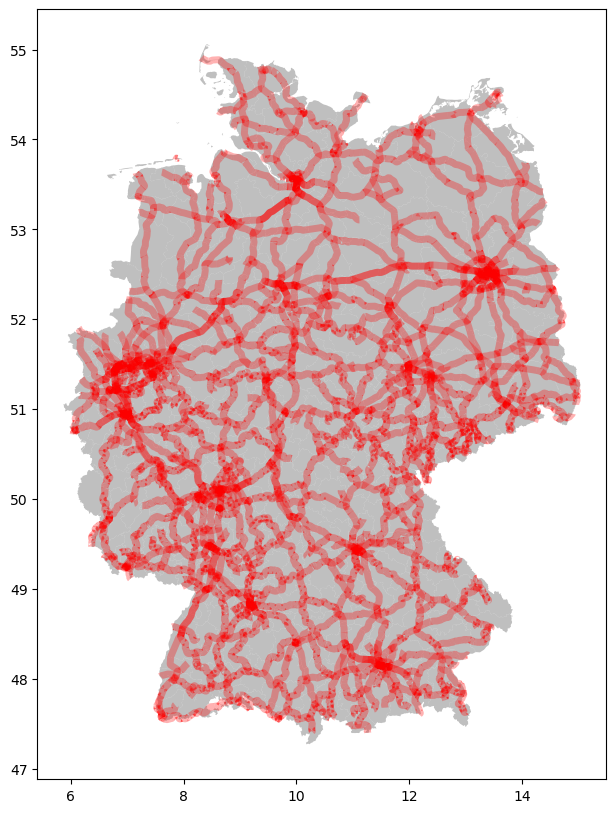

In [116]:

#data_routes = gpd.GeoDataFrame(data_routes, geometry=gpd.GeoSeries.from_wkt(data_routes['geometry']))

# GeoDataFrame 그리기

germany = gpd.read_file("/Users/jihakim/Desktop/project_DB/K-2021-AI014-2--AI1402--2023-12-11.geojson")
# change the crs coord
germany = germany.to_crs({'init': 'epsg:4326'} )

# 그래프 생성

fig, ax = plt.subplots(figsize=(10, 10))
# germany 그래프 그리기
germany.geometry.plot(ax=ax,color="gray", alpha=0.5, linewidth=1, marker=".")

# data_routes 그래프 그리기
data_routes.loc[:, "geometry"].plot(ax=ax,
                                         linewidth=5,
                                         alpha=0.3,
                                         color='red',
                                         markersize=0.1)

# 그래프 표시
plt.show()

In [126]:
data_rides = pd.read_csv("../dat/Zugfahrten_2016_12.csv", sep=";",  encoding='latin-1', date_parser="PROD_DATUM")
data_rides.columns = ["Station or stop", "Country", "Date", "Number of train rides", "Minutes of delay"]
data_rides = data_rides.sort_values(["Station or stop","Date"])

data_stations = pd.read_csv("../dat/GEO_Bahnstellen_EXPORT.csv", sep = ";", encoding = "latin-1")
data_stations.columns = ["Station or stop", "Name", "Country", "Coordinate Latitude", "Coordinate Longitude"]
data_stations = data_stations.sort_values(["Station or stop"])
# merge the two dataframes
data = pd.merge(data_rides, data_stations, on = "Station or stop")
data = data.drop(["Country_x"], axis = 1)


# rename the column "Country_y" to "Country"
data = data.rename(columns = {"Country_y": "Country"})
# exclude data in 2016-10-26 because every station has 0 delay 
data = data[data["Date"] != pd.to_datetime("2016-10-26")]
# Stations that never experienced delays greater than zero throughout the entire duration were also excluded from the dataset.
station_data = data.groupby(['Station or stop'])['Minutes of delay'].agg(
    {'sum'}).sort_values("sum").reset_index()
station_data.columns = ["Station or stop", "sum of delay"]
allzero_station = station_data[station_data['sum of delay'] ==0]['Station or stop'].tolist()
data = data[~ data['Station or stop'].isin(allzero_station)]
data = data.groupby(["Station or stop","Name", "Coordinate Latitude","Coordinate Longitude"]).sum().reset_index()
data["mean"] = data["Minutes of delay"] / data["Number of train rides"]
gdf_stations = gpd.GeoDataFrame(data, geometry = gpd.points_from_xy(data_mean["Coordinate Longitude"], data_mean["Coordinate Latitude"]))
gdf_stations["route_ids"] = None
# gdf_stations = gdf_stations.to_crs({'init': 'epsg:4326'} )

/var/folders/6d/6k3gy8t558517t4dg0xy4nlm0000gn/T/ipykernel_72059/1342336766.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(["Station or stop","Name", "Coordinate Latitude","Coordinate Longitude"]).sum().reset_index()


In [155]:
data = pd.merge(data_routes.assign(key=1), gdf_stations.assign(key=1), on='key').drop('key', 1)

/var/folders/6d/6k3gy8t558517t4dg0xy4nlm0000gn/T/ipykernel_72059/94818313.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = pd.merge(data_routes.assign(key=1), gdf_stations.assign(key=1), on='key').drop('key', 1)


In [167]:
data['distance'] = data['geometry_x'].distance(data['geometry_y'])
data = data[data["distance"] < 0.01] 

/var/folders/6d/6k3gy8t558517t4dg0xy4nlm0000gn/T/ipykernel_72059/558353898.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data['distance'] = data['geometry_x'].distance(data['geometry_y'])
/var/folders/6d/6k3gy8t558517t4dg0xy4nlm0000gn/T/ipykernel_72059/558353898.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  data['distance'] = data['geometry_x'].distance(data['geometry_y'])


In [177]:
stations = data.groupby(["strecke_nr","Station or stop","Name","geometry_y"])[["Number of train rides", "Minutes of delay"]].mean().reset_index()

In [182]:
stations.columns = ['strecke_nr', 'Station or stop', 'Name', 'geometry',
       'Number of train rides', 'Minutes of delay']

In [275]:
#data = pd.merge(stations, gdf_stations, on="strecke_nr")
data = pd.merge(stations.assign(key=1), stations.assign(key=1), on='key').drop('key', 1)

/var/folders/6d/6k3gy8t558517t4dg0xy4nlm0000gn/T/ipykernel_72059/1505208447.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = pd.merge(stations.assign(key=1), stations.assign(key=1), on='key').drop('key', 1)


In [282]:
data = data[ (data["strecke_nr_x"]==data["strecke_nr_y"] ) &
            (data["Station or stop_x"]!=data["Station or stop_y"])].reset_index(drop=True)
inter_data = data[(data["Station or stop_x"]==data["Station or stop_y"]) & 
                  (data["strecke_nr_x"]==data["strecke_nr_y"])]
data = gpd.GeoDataFrame(data, geometry="geometry_x")
data["distance"] = data["geometry_x"].distance(data['geometry_y'])
# c 열을 기준으로 그룹화하고, 각 그룹에서 최솟값을 갖는 행의 인덱스를 찾기
data['rank'] = data.groupby(['strecke_nr_x', 'Station or stop_x', 'Name_x', 'geometry_x'])['distance'].rank()

# 각 그룹에서 최솟값과 그 다음 최솟값을 갖는 행의 인덱스 찾기
min_indices = data[data['rank'] == 1].index
second_min_indices = data[data['rank'] == 2].index

data = pd.concat([data.iloc[min_indices ,:] , data.iloc[second_min_indices,:]], axis=0)

data = pd.concat([data, inter_data],axis=0).reset_index(drop=True)
data = gpd.GeoDataFrame(data, geometry="geometry_x")


In [283]:
data

,strecke_nr_x,Station or stop_x,Name_x,geometry_x,Number of train rides_x,Minutes of delay_x,strecke_nr_y,Station or stop_y,Name_y,geometry_y,Number of train rides_y,Minutes of delay_y,distance,rank
0,1000,80014241,FLENSBURG WEICHE,POINT (9.39917 54.76011),5827.0,14249.0,1000,80017046,FLENSBURG FRIEDENSWEG,POINT (9.39254 54.77022),5705.0,2264.0,0.012087,1.0
1,1000,80017046,FLENSBURG FRIEDENSWEG,POINT (9.39254 54.77022),5705.0,2264.0,1000,80014241,FLENSBURG WEICHE,POINT (9.39917 54.76011),5827.0,14249.0,0.012087,1.0
2,1005,80014241,FLENSBURG WEICHE,POINT (9.39917 54.76011),5827.0,14249.0,1005,80017046,FLENSBURG FRIEDENSWEG,POINT (9.39254 54.77022),5705.0,2264.0,0.012087,1.0
3,1005,80017046,FLENSBURG FRIEDENSWEG,POINT (9.39254 54.77022),5705.0,2264.0,1005,80014241,FLENSBURG WEICHE,POINT (9.39917 54.76011),5827.0,14249.0,0.012087,1.0
4,1022,80014084,OSTERROENFELD,POINT (9.72053 54.28520),5907.0,2832.0,1022,80072165,KIEL HBF,POINT (10.13217 54.31516),10.0,59.0,0.412726,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9705,6899,80245852,SALZWEDEL,POINT (11.17347 52.85637),1371.0,1730.0,6899,80130401,SCHNEGA,POINT (10.89149 52.87055),725.0,813.0,0.282344,2.0
9706,6899,80349746,RADEMIN,POINT (11.32383 52.81302),707.0,548.0,6899,80245811,BRUNAU-PACKEBUSCH,POINT (11.48459 52.75127),668.0,923.0,0.172209,2.0
9707,6925,80209171,BENTWISCH,POINT (12.21077 54.11745),2403.0,1507.0,6925,80270611,ROSTOCK SEEHAFEN,POINT (12.15873 54.11933),8171.0,64608.0,0.052073,2.0
9708,6925,80213553,ROSTOCK SEEHAFEN SUED,POINT (12.18378 54.10610),9008.0,7106.0,6925,80209171,BENTWISCH,POINT (12.21077 54.11745),2403.0,1507.0,0.029280,2.0


In [284]:
data.columns
data[['Station or stop_x', 'Name_x', 'geometry_x','Station or stop_y', 'Name_y', 'geometry_y',
     'Number of train rides_x', 'Minutes of delay_x',
     'Number of train rides_y','Minutes of delay_y', 'distance']].drop_duplicates()

,Station or stop_x,Name_x,geometry_x,Station or stop_y,Name_y,geometry_y,Number of train rides_x,Minutes of delay_x,Number of train rides_y,Minutes of delay_y,distance
0,80014241,FLENSBURG WEICHE,POINT (9.39917 54.76011),80017046,FLENSBURG FRIEDENSWEG,POINT (9.39254 54.77022),5827.0,14249.0,5705.0,2264.0,0.012087
1,80017046,FLENSBURG FRIEDENSWEG,POINT (9.39254 54.77022),80014241,FLENSBURG WEICHE,POINT (9.39917 54.76011),5705.0,2264.0,5827.0,14249.0,0.012087
4,80014084,OSTERROENFELD,POINT (9.72053 54.28520),80072165,KIEL HBF,POINT (10.13217 54.31516),5907.0,2832.0,10.0,59.0,0.412726
5,80072165,KIEL HBF,POINT (10.13217 54.31516),80014084,OSTERROENFELD,POINT (9.72053 54.28520),10.0,59.0,5907.0,2832.0,0.412726
6,80072165,KIEL HBF,POINT (10.13217 54.31516),80319376,MEIMERSDORF OST,POINT (10.13570 54.29439),10.0,59.0,1900.0,3682.0,0.021067
...,...,...,...,...,...,...,...,...,...,...,...
9704,80245811,BRUNAU-PACKEBUSCH,POINT (11.48459 52.75127),80349746,RADEMIN,POINT (11.32383 52.81302),668.0,923.0,707.0,548.0,0.172209
9705,80245852,SALZWEDEL,POINT (11.17347 52.85637),80130401,SCHNEGA,POINT (10.89149 52.87055),1371.0,1730.0,725.0,813.0,0.282344
9706,80349746,RADEMIN,POINT (11.32383 52.81302),80245811,BRUNAU-PACKEBUSCH,POINT (11.48459 52.75127),707.0,548.0,668.0,923.0,0.172209
9707,80209171,BENTWISCH,POINT (12.21077 54.11745),80270611,ROSTOCK SEEHAFEN,POINT (12.15873 54.11933),2403.0,1507.0,8171.0,64608.0,0.052073


In [285]:
# [i for i in inter_data.Name_x if "STUTT" in i]
# 'STUTTGART HBF',
# 'FRANKFURT AM MAIN STADION'
data[data["Name_x"] == 'FRANKFURT (MAIN) AUSSENBAHNHOF']


,strecke_nr_x,Station or stop_x,Name_x,geometry_x,Number of train rides_x,Minutes of delay_x,strecke_nr_y,Station or stop_y,Name_y,geometry_y,Number of train rides_y,Minutes of delay_y,distance,rank
2137,3520,80106179,FRANKFURT (MAIN) AUSSENBAHNHOF,POINT (8.63658 50.09800),1095.0,1654.0,3520,80117119,FRANKFURT MAINZER LANDSTRASSE,POINT (8.62820 50.10041),3450.0,865.0,0.008726,1.0
2324,3603,80106179,FRANKFURT (MAIN) AUSSENBAHNHOF,POINT (8.63658 50.09800),1095.0,1654.0,3603,80117119,FRANKFURT MAINZER LANDSTRASSE,POINT (8.62820 50.10041),3450.0,865.0,0.008726,1.0
2345,3610,80106179,FRANKFURT (MAIN) AUSSENBAHNHOF,POINT (8.63658 50.09800),1095.0,1654.0,3610,80117119,FRANKFURT MAINZER LANDSTRASSE,POINT (8.62820 50.10041),3450.0,865.0,0.008726,1.0
2359,3613,80106179,FRANKFURT (MAIN) AUSSENBAHNHOF,POINT (8.63658 50.09800),1095.0,1654.0,3613,80117119,FRANKFURT MAINZER LANDSTRASSE,POINT (8.62820 50.10041),3450.0,865.0,0.008726,1.0
2363,3618,80106179,FRANKFURT (MAIN) AUSSENBAHNHOF,POINT (8.63658 50.09800),1095.0,1654.0,3618,80117119,FRANKFURT MAINZER LANDSTRASSE,POINT (8.62820 50.10041),3450.0,865.0,0.008726,1.0
2367,3620,80106179,FRANKFURT (MAIN) AUSSENBAHNHOF,POINT (8.63658 50.09800),1095.0,1654.0,3620,80117119,FRANKFURT MAINZER LANDSTRASSE,POINT (8.62820 50.10041),3450.0,865.0,0.008726,1.0
2369,3621,80106179,FRANKFURT (MAIN) AUSSENBAHNHOF,POINT (8.63658 50.09800),1095.0,1654.0,3621,80117119,FRANKFURT MAINZER LANDSTRASSE,POINT (8.62820 50.10041),3450.0,865.0,0.008726,1.0
2372,3622,80106179,FRANKFURT (MAIN) AUSSENBAHNHOF,POINT (8.63658 50.09800),1095.0,1654.0,3622,80117119,FRANKFURT MAINZER LANDSTRASSE,POINT (8.62820 50.10041),3450.0,865.0,0.008726,1.0
2374,3623,80106179,FRANKFURT (MAIN) AUSSENBAHNHOF,POINT (8.63658 50.09800),1095.0,1654.0,3623,80117119,FRANKFURT MAINZER LANDSTRASSE,POINT (8.62820 50.10041),3450.0,865.0,0.008726,1.0
2379,3626,80106179,FRANKFURT (MAIN) AUSSENBAHNHOF,POINT (8.63658 50.09800),1095.0,1654.0,3626,80117119,FRANKFURT MAINZER LANDSTRASSE,POINT (8.62820 50.10041),3450.0,865.0,0.008726,1.0


In [290]:
import pandas as pd
import networkx as nx

G = nx.from_pandas_edgelist(data, source = "Name_x" , target = "Name_y" ,edge_attr="Minutes of delay_y")


# 'STUTTGART HBF',
# 'FRANKFURT AM MAIN STADION'

# 'A'에서 'D'까지의 모든 최단 경로 찾기
shortest_paths = nx.all_shortest_paths(G, source='STUTTGART-MUENSTER', 
                                       target='FRANKFURT AM MAIN STADION', 
                                       weight='Minutes of delay_y')

for path in shortest_paths:
    print(path)

['STUTTGART-MUENSTER', 'STUTTGART NUERNBERGER STRASSE ABZW', 'WAIBLINGEN', 'WINNENDEN', 'BACKNANG', 'OPPENWEILER (WUERTT)', 'SULZBACH (MURR)', 'MURRHARDT', 'FORNSBACH', 'FICHTENBERG', 'SCHWAEBISCH HALL-HESSENTAL', 'HEILBRONN HBF', 'NECKARSULM', 'BAD FRIEDRICHSHALL KOCHENDORF AUDI', 'BAD FRIEDRICHSHALL-JAGSTFELD', 'GUNDELSHEIM(NECKAR)', 'MOSBACH-NECKARELZ', 'ZWINGENBERG (BADEN)', 'EBERBACH', 'BABENHAUSEN (HESS)', 'HANAU HBF', 'HANAU NORD', 'BRUCHKOEBEL', 'NIDDERAU', 'FRIEDBERG(HESS)', 'FFM GALLUSWARTE', 'FRANKFURT MAIN-NECKAR-BRUECKE', 'FRANKFURT (MAIN) AUSSENBAHNHOF', 'FRANKFURT AM MAIN STADION']
['STUTTGART-MUENSTER', 'STUTTGART NUERNBERGER STRASSE ABZW', 'WAIBLINGEN', 'WINNENDEN', 'BACKNANG', 'OPPENWEILER (WUERTT)', 'SULZBACH (MURR)', 'MURRHARDT', 'FORNSBACH', 'FICHTENBERG', 'SCHWAEBISCH HALL-HESSENTAL', 'HEILBRONN GBF', 'NECKARSULM', 'BAD FRIEDRICHSHALL KOCHENDORF AUDI', 'BAD FRIEDRICHSHALL-JAGSTFELD', 'GUNDELSHEIM(NECKAR)', 'MOSBACH-NECKARELZ', 'ZWINGENBERG (BADEN)', 'EBERBACH', 'B

In [300]:
shortest_paths = nx.all_shortest_paths(G, 
                                       source='STUTTGART-MUENSTER', 
                                       target='FRANKFURT AM MAIN STADION', 
                                       weight='Minutes of delay_y')

In [301]:
shortest_path = [i for i in shortest_paths]

In [306]:
stations[stations["Name"].isin(shortest_paths[0])]

TypeError: 'generator' object is not subscriptable

In [305]:
shortest_path[0]

['STUTTGART-MUENSTER',
 'STUTTGART NUERNBERGER STRASSE ABZW',
 'WAIBLINGEN',
 'WINNENDEN',
 'BACKNANG',
 'OPPENWEILER (WUERTT)',
 'SULZBACH (MURR)',
 'MURRHARDT',
 'FORNSBACH',
 'FICHTENBERG',
 'SCHWAEBISCH HALL-HESSENTAL',
 'HEILBRONN HBF',
 'NECKARSULM',
 'BAD FRIEDRICHSHALL KOCHENDORF AUDI',
 'BAD FRIEDRICHSHALL-JAGSTFELD',
 'GUNDELSHEIM(NECKAR)',
 'MOSBACH-NECKARELZ',
 'ZWINGENBERG (BADEN)',
 'EBERBACH',
 'BABENHAUSEN (HESS)',
 'HANAU HBF',
 'HANAU NORD',
 'BRUCHKOEBEL',
 'NIDDERAU',
 'FRIEDBERG(HESS)',
 'FFM GALLUSWARTE',
 'FRANKFURT MAIN-NECKAR-BRUECKE',
 'FRANKFURT (MAIN) AUSSENBAHNHOF',
 'FRANKFURT AM MAIN STADION']